In [16]:
import tensorflow as tf
import numpy as np
from time import time
from utils import plot_images, read_mnist_data
from os.path import exists

In [2]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


In [100]:
def generator(z, training=True):
    x_gen = tf.layers.dense(z, 1024, tf.nn.relu, name='fc1')
    x_gen = tf.layers.batch_normalization(x_gen, training=training, name='bn1')
    print(x_gen.shape)
    x_gen = tf.layers.dense(z, 7 * 7 * 128, tf.nn.relu, name='fc2')
    x_gen = tf.layers.batch_normalization(x_gen, training=training, name='bn2')
    print(x_gen.shape)
    x_gen = tf.reshape(x_gen, (-1, 7, 7, 128))
    print(x_gen.shape)
    x_gen = tf.layers.conv2d_transpose(x_gen, 128, (5, 5), (2, 2), padding='same', activation=tf.nn.relu, name='tconv1')
    print(x_gen.shape)
    x_gen = tf.layers.conv2d_transpose(x_gen, 1, (5, 5), (2, 2), padding='same', activation=tf.nn.relu, name='tconv2')
    print(x_gen.shape)
    x_gen = tf.reshape(x_gen, (-1, 784))
    return x_gen

In [101]:
def discriminator(x, training=True):
    p = tf.reshape(x, (-1, 28, 28, 1))
    print(p.shape)
    p = tf.layers.conv2d(p, 11, (5, 5), (2, 2), padding='same', activation=tf.nn.relu, name='conv1')
    print(p.shape)
    p = tf.layers.conv2d(p, 75, (5, 5), (2, 2), padding='same', activation=tf.nn.relu, name='conv2')
    print(p.shape)
    p = tf.reshape(p, (-1, 7 * 7 * 75))
    print(p.shape)
    p = tf.layers.dense(p, 1024, tf.nn.relu, name='fc1')
    p = tf.layers.batch_normalization(p, training=training, name='bn1')
    print(p.shape)
    p = tf.layers.dense(p, 1, tf.nn.sigmoid, name='fc2')
    print(p.shape)
    return p

In [102]:
z_dim = 128

tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    
with tf.variable_scope('generator'):
    x_gen = generator(z)
    
with tf.variable_scope('discriminator'):
    p_x = discriminator(x)
    tf.get_variable_scope().reuse_variables()
    p_g = discriminator(x_gen)
    
    
with tf.name_scope('optimizer'):
    loss_g = 0.5 * tf.reduce_mean((p_g - 1)**2)
    loss_d = 0.5 * (tf.reduce_mean((p_x - 1)**2) + tf.reduce_mean(p_g**2))
    optimizer_g = tf.train.AdamOptimizer(1e-4).minimize(loss_g, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimizer_d = tf.train.AdamOptimizer(1e-4).minimize(loss_d, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator'))

tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
summ = tf.summary.merge_all()

(?, 1024)
(?, 6272)
(?, 7, 7, 128)
(?, 14, 14, 128)
(?, 28, 28, 1)
(?, 28, 28, 1)
(?, 14, 14, 11)
(?, 7, 7, 75)
(?, 3675)
(?, 1024)
(?, 1)
(?, 28, 28, 1)
(?, 14, 14, 11)
(?, 7, 7, 75)
(?, 3675)
(?, 1024)
(?, 1)


In [65]:
def plot_generated_images(sess):
    generated_images = sess.run(x_gen, feed_dict={z: np.random.randn(11, z_dim)})
    plot_images(generated_images)

In [66]:
batch_size = 256
batches_per_epoch = int(data.train.num_examples / batch_size)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def optimize(epochs=1):
    start_time = time()
    
    writer = tf.summary.FileWriter('checkpoints/LSGAN', tf.get_default_graph())
    saver = tf.train.Saver()
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                x_batch, _ = data.train.next_batch(batch_size)
                z_batch = np.random.randn(batch_size, z_dim)
                for _ in range(2):
                    sess.run(optimizer_g, feed_dict={x: x_batch, z: z_batch})

                sess.run(optimizer_d, feed_dict={x: x_batch, z: z_batch})

                if batch % 1000 == 0:
                    writer.add_summary(sess.run(summ, feed_dict={x: x_batch, z: z_batch}), global_step=epoch * batches_per_epoch + batch)
            
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_generated_images(sess)
            
        saver.save(sess, 'checkpoints/LSGAN/LSGAN', write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))

1 / 10 (10.0%)


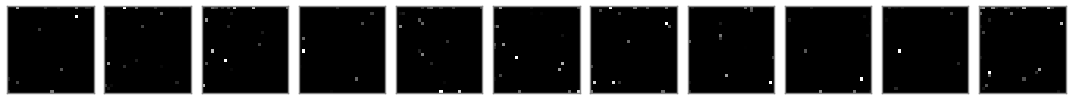

2 / 10 (20.0%)


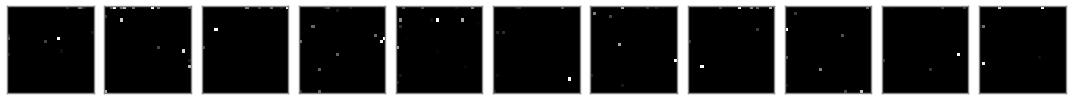

3 / 10 (30.0%)


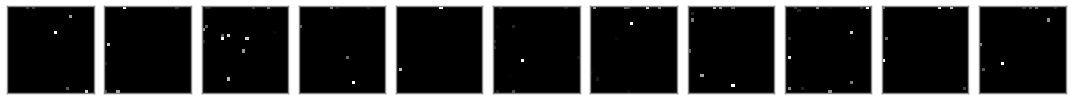

4 / 10 (40.0%)


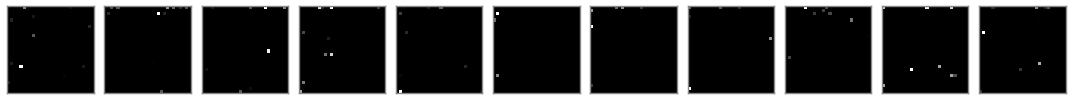

5 / 10 (50.0%)


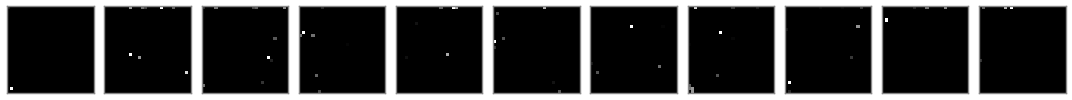

6 / 10 (60.0%)


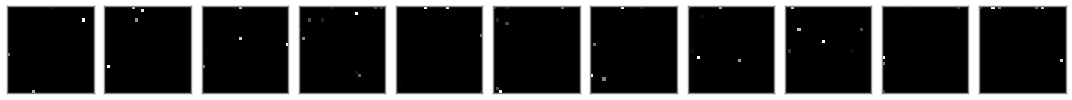

KeyboardInterrupt: 

In [105]:
if exists('checkpoints/LSGAN/LSGAN.data-00000-of-00001'):
    with tf.Session(config=config) as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'checkpoints/LSGAN/LSGAN')
        
        for _ in range(10):
            plot_generated_images(sess)
else:
    optimize(10)